In [1]:
import random
import os
import torch
import torchaudio
import torch.nn.functional as F
import nbimporter
from torch.utils.data import Dataset, DataLoader
import pickle
import sys
import pandas as pd

import torch.nn as nn
from torch import optim



In [2]:

import matplotlib.pyplot as plt
import pylab


In [3]:
#from classio import Io


In [4]:
from essentia import DebuggingModule
sys.path.append('../')

In [5]:
# Para una visualización más interactiva defino esta función que básicamente tiene todo lo que me gusta en cuanto a gráficas.

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use([ 'dark_background','bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)
    
    
    

In [6]:
# Definimos el tamaño de las gráficas
set_default(figsize=(16, 8))

In [7]:
df = pd.read_csv('/media/birds/BirdsDataFrame.csv')
df=df.drop(['Unnamed: 0'], axis=1)
df

especies=df['Species'].unique().tolist()

In [8]:
class Io:
    
        def __init__(self):
            pass
       
        
        def spectrogram(self,audio_path = None):
            waveform, sample_rate = torchaudio.load(audio_path)
           # print("Shape of waveform: {}".format(waveform.size()))
            #print("Sample rate of waveform: {}".format(sample_rate))

            # Plot de waveforms

            # plt.figure()
            # plt.plot(waveform.t().numpy())

            tensor = torchaudio.transforms.Spectrogram()(waveform) #many arguments to modificate the spectrogram 

          #  print("Shape of spectrogram: {}".format(tensor.size()))

            #plt.figure()
            #pylab.matshow(tensor.log2()[0,:,:].numpy(), cmap=pylab.get_cmap('plasma'))

            self.tensor = tensor





In [9]:
class AvesDataset:
    """Class of dataset"""
    especies=df['Species'].unique().tolist()

    def __init__(self, nAncla=1,nPos=1, nNeg=1, winSize=50):
        self.nAncla=nAncla
        self.nPos=nPos
        self.nNeg=nNeg
        self.winSize=winSize
        
       
        
   
    def pathRandSpectSam(self, path, winSize):
        io = Io()
        io.spectrogram(audio_path=path)
        spectogram = io.tensor
        startIdx = random.randint(0, spectogram.size()[2] - winSize)
        spectogram = spectogram[:, :, startIdx:startIdx+winSize]
        
        return spectogram[0].view(1,-1,50)


    def __len__(self):
        
        return 40
    
    def __getitem__(self,iterator):
        #iteration?
        pair=random.sample(especies,2)
        AnclaSpects = []   # Serán del mismo tipo que los positivos
        anchPosSpects = []
        negaSpects=[]
        AnclaPos=df['FileName'][df['Species'] == pair[0]].to_list()
        anchPositive=df['FileName'][df['Species'] == pair[0]].to_list()
        negative=df['FileName'][df['Species'] == pair[1]].to_list()
        AnclaPaths=random.sample(AnclaPos,self.nAncla)
        anchPosPaths=random.sample(anchPositive,self.nPos)
        negaPaths = random.sample(negative, self.nNeg)
        

        for path in AnclaPaths:
            path='/media/birds/data/'+path
            tempSpec = self.pathRandSpectSam(path, self.winSize)
            AnclaSpects.append(tempSpec)
            
        
        for path in anchPosPaths:
            path='/media/birds/data/'+path
            tempSpec = self.pathRandSpectSam(path, self.winSize)
            anchPosSpects.append(tempSpec)

       

        for path in negaPaths:
            path='/media/birds/data/'+path
            tempSpec = self.pathRandSpectSam(path, self.winSize)
            negaSpects.append(tempSpec)

            print(tempSpec.shape)
            
            
        return { 
        'spectograms': {'Ancla': AnclaSpects,
                        'positive': anchPosSpects,
                        'negative': negaSpects
                       },
        'labels': {'Ancla': 1,
                                'positive': 1,
                                   'negative': 0
                  }}
    
# 1 para especies iguales y 0 para diferentes
 

In [10]:
AvesData = AvesDataset()

In [11]:
AvesData.__getitem__(1)

torch.Size([1, 201, 50])


{'spectograms': {'Ancla': [tensor([[[2.8380e-02, 2.8006e-02, 1.5745e-03,  ..., 8.5924e-03,
             4.7333e-04, 1.0009e-01],
            [1.2397e-02, 1.0388e-02, 3.3604e-03,  ..., 7.1431e-03,
             1.8114e-02, 4.0077e-02],
            [3.1056e-03, 4.8822e-03, 1.7087e-03,  ..., 1.6592e-02,
             3.3002e-02, 8.6320e-03],
            ...,
            [2.3538e-08, 2.6751e-08, 2.0544e-08,  ..., 1.2662e-08,
             4.2244e-08, 1.6526e-08],
            [1.4374e-08, 3.3232e-08, 1.8739e-08,  ..., 2.8223e-08,
             3.1893e-08, 1.6682e-08],
            [4.6607e-09, 4.7506e-08, 1.0620e-08,  ..., 1.1305e-08,
             5.1319e-11, 6.5157e-09]]])],
  'positive': [tensor([[[1.1207e-07, 2.9339e-09, 8.4536e-08,  ..., 6.0891e-07,
             8.2640e-07, 8.7139e-09],
            [9.7108e-08, 1.3294e-07, 2.1765e-07,  ..., 8.7591e-07,
             9.4121e-07, 1.8809e-07],
            [2.6160e-07, 1.1319e-06, 7.0225e-07,  ..., 8.0065e-07,
             1.6194e-06, 4.3855e-08]

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.conv2 = nn.Conv2d(3, 5, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2115, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [13]:
#Modelo de red neuronal

class SiameseNetwork(nn.Module):
    
    def __init__(self, use_pretrained, feature_extracting, num_classes):
        super(SiameseNetwork, self).__init__()
        self.model_ft = Net()
        self.fc_mse = nn.Sequential(
            nn.Dropout(),
            nn.Linear(10 * 2, 2, bias = True),
            nn.ReLU(inplace = True),
            nn.Linear(2, 1, bias = True)
        )


    def forward_once(self, x):
        output = self.model_ft(x)
        return output.view(output.size(0), -1)

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
    
        return output1,output2,output3

In [14]:


train_dataloader = DataLoader(AvesData,
                              shuffle = True,
                              num_workers = 2,
                              batch_size = 2)



In [15]:


net = SiameseNetwork(True, True, 512).cuda()
criterion = nn.TripletMarginLoss(margin = 1.0).cuda()
optimizer = optim.Adam(net.parameters(), lr = 1e-4)
net.train()


SiameseNetwork(
  (model_ft): Net(
    (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=2115, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
  (fc_mse): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=20, out_features=2, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [16]:
for name, param in net.named_parameters():
    if param.requires_grad == True:
        print(name)

model_ft.conv1.weight
model_ft.conv1.bias
model_ft.conv2.weight
model_ft.conv2.bias
model_ft.fc1.weight
model_ft.fc1.bias
model_ft.fc2.weight
model_ft.fc2.bias
model_ft.fc3.weight
model_ft.fc3.bias
fc_mse.1.weight
fc_mse.1.bias
fc_mse.3.weight
fc_mse.3.bias


In [17]:
counter = []
loss_history = [] 
iteration_number = 0

In [19]:
#training
for epoch in range(0, 10):
    
    for i, data in enumerate(train_dataloader, 0):
        #print(data)
        
        imgAncla=data["spectograms"]["Ancla"][0]
        img1=data["spectograms"]["positive"][0]
        img0=data["spectograms"]["negative"][0]
        
        print(imgAncla.byte())
        #imgAncla,img1, img0, _, _, _ = data
        
        imgAncla,img1, img0 = imgAncla.cuda(), img1.cuda(), img0.cuda()
        print(imgAncla.byte())
        optimizer.zero_grad()
        output_Ancla, output_1, output_0 = net(imgAncla, img1, img0)
        
        loss = criterion(output_Ancla, output_1, output_0 )
        loss.backward()
        optimizer.step()
    print("Epoch number {}\n Current loss_1 {}\n".format(epoch, loss.item()))
    iteration_number += 1
    counter.append(iteration_number)
    loss_history.append(loss.item())

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
    

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 1,  ..., 0, 0, 0],
          [1, 0, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 1,  ..., 0, 0, 0],
          [1, 0, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 

torch.Size([1, 201, 50])
tensor([[[[  0,   0,   0,  ...,   4,   3,   0],
          [  0,   0,   0,  ...,   1,   1,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[ 60,  59, 183,  ...,  78,  29,  16],
          [ 28,  48,  86,  ...,  39,   2,  14],
          [  9,   6,   4,  ...,   9,   7,   6],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[  0,   0,   0,  ...,   4,   3,   0],
          [  0,   0,   0,  ...,   1,   1,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[ 60,  59, 183,  ...,  78,

torch.Size([1, 201, 50])
tensor([[[[0, 3, 2,  ..., 3, 2, 0],
          [0, 5, 2,  ..., 4, 0, 2],
          [1, 3, 4,  ..., 2, 0, 5],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 3, 2,  ..., 3, 2, 0],
          [0, 5, 2,  ..., 4, 0, 2],
          [1, 3, 4,  ..., 2, 0, 5],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', d

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[  6,   1,   1,  ...,   7,  19,   0],
          [  6,   6,   2,  ...,   7,   3,   5],
          [  1,   3,   0,  ...,   1,   1,   1],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[ 29,  93, 109,  ...,   0,   0,   1],
          [ 13,  84, 135,  ...,   1,   2,   4],
          [ 16,  16,  50,  ...,   1,  10,  16],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[  6,   1,   1,  ...,   7,  19,   0],
          [  6,   6,   2,  ...,   7,   3,   5],
          [  1,   3,   0,  ...,   1,   1,   1],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 0, 0,  ..., 1, 0, 1],
          [1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 0, 0,  ..., 1, 0, 1],
          [1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 3, 8,  ..., 0, 0, 0],
          [0, 1, 3,  ..., 0, 0, 3],
          [0, 1, 0,  ..., 1, 0, 2],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 3, 8,  ..., 0, 0, 0],
          [0, 1, 3,  ..., 0, 0, 3],
          [0, 1, 0,  ..., 1, 0, 2],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[ 40,  79,  67,  ...,  34, 125, 194],
          [ 12,  19,  14,  ...,  13,  32,  48],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  1,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[ 40,  79,  67,  ...,  34, 125, 194],
          [ 12,  19,  14,  ...,  13,  32,  48],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0

torch.Size([1, 201, 50])torch.Size([1, 201, 50])

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
       

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[32, 33, 74,  ..., 30, 11,  2],
          [ 8, 11, 32,  ..., 16,  5,  1],
          [ 0,  5,  1,  ...,  4,  0,  1],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 1,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]], dtype=torch.uint8)
tensor([[[[32, 33, 74,  ..., 30, 11,  2],
          [ 8, 11, 32,  ..., 16,  5,  1],
          [ 0,  5,  1,  ...,  4,  0,  1],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  0],
  

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[ 56,  54,   0,  ...,   7,   3,  14],
          [ 68,  32,   0,  ...,   7,   1,   3],
          [ 34,   3,   0,  ...,   5,   2,   1],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[ 87,   9, 175,  ...,  48, 255, 159],
          [ 34,  11,  51,  ...,  20,  76,  50],
          [  1,   1,   0,  ...,   1,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[ 56,  54,   0,  ...,   7,   3,  14],
          [ 68,  32,   0,  ...,   7,   1,   3],
          [ 34,   3,   0,  ...,   5,   2,   1],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 1, 0,  ..., 2, 2, 0],
          [0, 0, 0,  ..., 1, 2, 0],
          [0, 0, 0,  ..., 0, 1, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 1, 0,  ..., 2, 2, 0],
          [0, 0, 0,  ..., 1, 2, 0],
          [0, 0, 0,  ..., 0, 1, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 4, 3,  ..., 1, 5, 5],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 4, 3,  ..., 1, 5, 5],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[  0,   0,   4,  ...,   2,   0,   6],
          [  1,   0,   2,  ...,   0,   2,   2],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,  64, 199,  ...,  14,   3,  92],
          [ 25,  20,  87,  ...,  18,   6,  62],
          [133,  15,  11,  ...,   7,  29,  22],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[  0,   0,   4,  ...,   2,   0,   6],
          [  1,   0,   2,  ...,   0,   2,   2],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[  1,   0,   1,  ...,   0,   0,   8],
          [ 31,  80,  16,  ...,  10,  22,   2],
          [143, 176,  14,  ...,  93,  58,  21],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8)
tensor([[[[  1,   0,   1,  ...,   0,   0,   8],
          [ 31,  80,  16,  ...,  10,  22,   2],
          [143, 176,  14,  ...,  93,  58,  21],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,  

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  1, 10,  ...,  2,  4,  3],
          [ 0,  0,  7,  ...,  2,  2,  1],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]], dtype=torch.uint8)
tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  1, 10,  ...,  2,  4,  3],
          [ 0,  0,  7,  ...,  2,  2,  1],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 1, 1,  ..., 0, 0, 0],
          [0, 2, 0,  ..., 0, 0, 0],
          [0, 2, 0,  ..., 1, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 1, 1,  ..., 0, 0, 0],
          [0, 2, 0,  ..., 0, 0, 0],
          [0, 2, 0,  ..., 1, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
       

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ..., 10,  1,  0],
          [ 0,  0,  1,  ...,  2,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]], dtype=torch.uint8)
tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ..., 10,  1,  0],
  

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[31, 14,  4,  ...,  5,  5,  4],
          [ 8,  3,  1,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  1],
          [ 2,  0,  0,  ...,  7,  0,  6],
          [ 3,  0,  1,  ...,  7,  1,  4],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]], dtype=torch.uint8)
tensor([[[[31, 14,  4,  ...,  5,  5,  4],
          [ 8,  3,  1,  ...,  1,  1,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 0,  0,  0,  ...,  0,  0,  1],
          [ 2,  0,  0,  ...,  7,  0,  6],
          [ 3,  0,  1,  ...,  7,  1

torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.uint8)
torch.Size([2, 2115])
torch.Size([2, 2115])
torch.Size([2, 2115])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
torch.Size([1, 201, 50])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,

torch.Size([1, 201, 50])
tensor([[[[0, 2, 0,  ..., 0, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[0, 2, 0,  ..., 0, 1, 1],
          [1, 1, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', d

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.plot(counter, loss_history_1, label='Positivos')
plt.plot(counter, loss_history_0, label='Negativos')
plt.title('MSE Positivos y Negativos')
plt.xlabel('Epochs')
plt.ylabel('Loss_1')
plt.rc('font', size = 15)
plt.legend()
plt.grid()
plt.show()


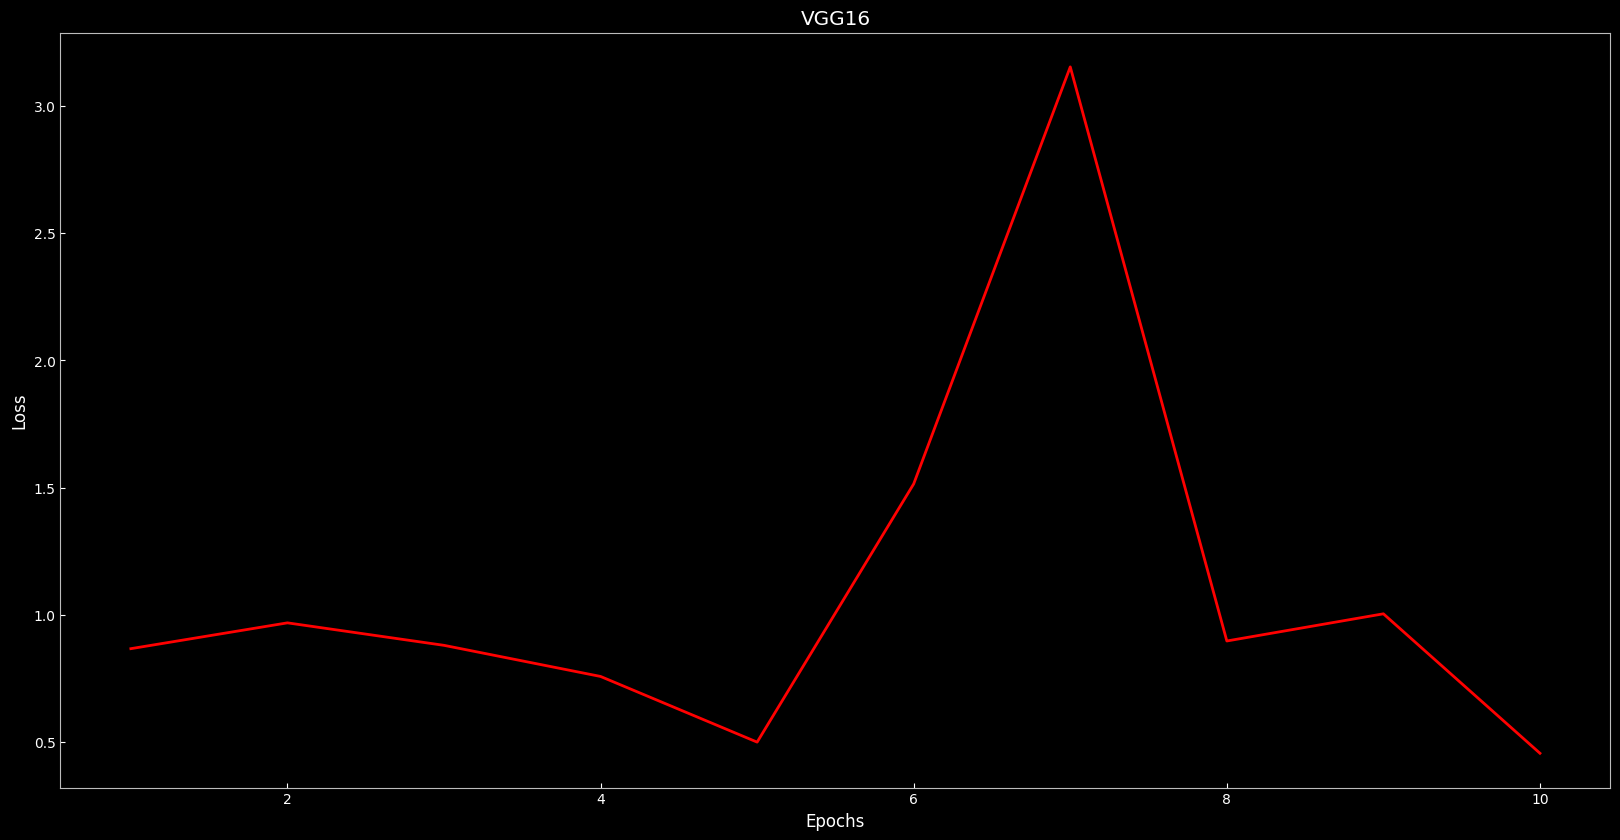

In [20]:


fig = plt.figure(figsize = (20, 10))
plt.plot(counter, loss_history, 'r')
plt.title('VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.rc('font', size = 15)
plt.grid()
plt.show()

